In [4]:
import xarray as xr
import numpy as np

import dask.array as da

import matplotlib.pyplot as plt
import numpy as np

#%pip install torch
import torch 
import torch.nn as nn
#from tensorflow.keras.callbacks import EarlyStopping
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, Dropout, Linear, MSELoss, L1Loss

#"""
%pip install torchsummary
%pip install torchvision
%pip install tensorboard
#"""

from torchsummary import summary
#from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Dropout

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import tensorboard
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

print('loaded')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
loaded


In [5]:
gpu_bool = torch.cuda.is_available()
print(gpu_bool)

True


In [6]:
zarr_ds = xr.open_zarr(store="~/shared-public/mind_the_chl_gap/IO.zarr", consolidated=True)  # get data

zarr_sliced = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))  # choose long and lat

all_nan_CHL = np.isnan(zarr_sliced.CHL).all(dim=["lon", "lat"]).compute()  # find sample indices where CHL is NaN

zarr_CHL = zarr_sliced.sel(time=(all_nan_CHL == False))  # select samples with CHL not NaN

zarr_CHL = zarr_CHL.sortby('time')
zarr_CHL = zarr_CHL.sel(time=slice('2020-01-01', '2020-12-31'))
zarr_CHL

<xarray.Dataset>
Dimensions:                       (time: 366, lat: 149, lon: 181)
Coordinates:
  * lat                           (lat) float32 32.0 31.75 31.5 ... -4.75 -5.0
  * lon                           (lon) float32 45.0 45.25 45.5 ... 89.75 90.0
  * time                          (time) datetime64[ns] 2020-01-01 ... 2020-1...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 dask.array<chunksize=(149, 181), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

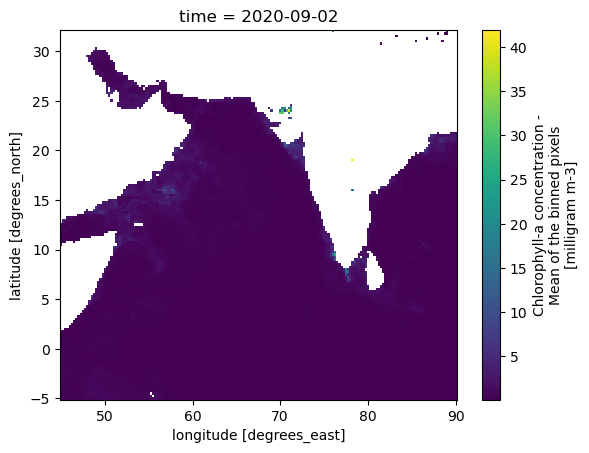

In [8]:
p = zarr_CHL.sel(time='2020-09-02').CHL.plot(y='lat', x='lon')

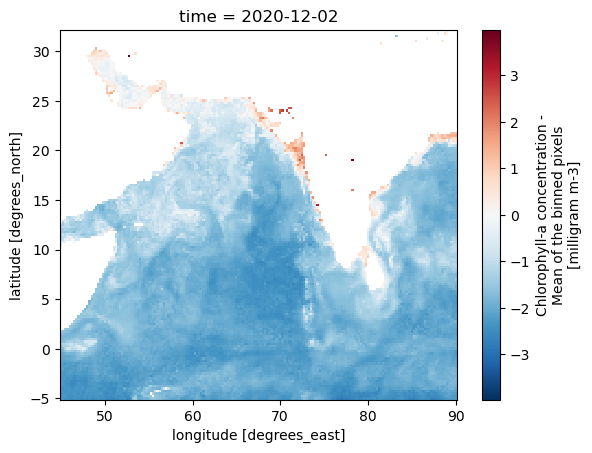

In [9]:
np.log(zarr_CHL.sel(time='2020-12-02').CHL).plot(y='lat', x='lon')

In [10]:
def log_label(data, label):
    data_logged = data.copy()
    data_logged[label] = np.log(data[label]).copy()
    return data_logged

# Add more preprocessing later
def preprocess_data(data, features, label):
    # log CHL
    data_logged = log_label(data, label)

    # save all features and labels in one list
    sel_data_list = []
    for var in (features + [label]):
        sel_var_data = data_logged[var]
        sel_var_data = da.where(da.isnan(sel_var_data), 0.0, sel_var_data)
        sel_data_list.append(sel_var_data)

    # reassign datatype of list to dask array
    sel_data_da =  da.array(sel_data_list)
    # of dimensions (var, time, lat, lon)
    return sel_data_da


# 
def data_prep(data, window_size=1):
    X_orig = data
    y_orig = data[-1]
    
    X_orig = np.moveaxis(X_orig, 0, -1)
    length = X_orig.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(X_orig[i: i + window_size])
        y.append(y_orig[i + window_size])

    X, y = da.array(X), da.array(y)

    return X, y


def time_series_split(X, y, split_ratio):
    total_length = X.shape[0]
    
    train_end = int(total_length * split_ratio[0])
    val_end = int(total_length * (split_ratio[0] + split_ratio[1]))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end: val_end], y[train_end: val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return (X_train, y_train,
            X_val, y_val,
            X_test, y_test)
    


In [12]:
features = ['sst', 'so']  # Curr Features: Sea Surface Temp (K), Sea Salinity Concentration (m**-3 or PSL). [Excluding Topography/Bathymetry (m)]
label = 'CHL'  # Curr Label: : chlorophyll-a concentration (mg/m**3) [Not taking uncertainty into consideration for now]
model_data = preprocess_data(zarr_CHL, features, label)

window_size = 1
X, y = data_prep(model_data, window_size=window_size)
print(X.shape)

split_ratio = [.7, .2, .1]
X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y, split_ratio)
X_train = np.moveaxis(X_train[:, 0, :, :, :], 3, 0)
X_val = np.moveaxis(X_val[:, 0, :, :, :], 3, 0)
X_test = np.moveaxis(X_test[:, 0, :, :, :], 3, 0)


(365, 1, 149, 181, 3)


In [13]:
print(X_train.shape)
print(type(X_train))
y_train.shape

(3, 255, 149, 181)
<class 'dask.array.core.Array'>


(255, 149, 181)

In [14]:
# Convert Dask to NumPy and then to PyTorch tensors
def convert_inputs(X_input, y_input):
    X_inp_np = X_input.compute()
    y_inp_np = y_input.compute()
    
    X_inp_tensor = torch.tensor(X_inp_np, dtype=torch.float32)
    y_inp_tensor = torch.tensor(y_inp_np, dtype=torch.float32).unsqueeze(0)
    
    # Permute to make batch-first
    X_inp_tensor = X_inp_tensor.permute(1, 0, 2, 3)  # Shape: (255, 3, 149, 181)
    y_inp_tensor = y_inp_tensor.permute(1, 0, 2, 3)  # Shape: (255, 1, 149, 181)
    
    # Create TensorDataset and DataLoader
    inp_dataset = TensorDataset(X_inp_tensor, y_inp_tensor)
    inp_loader = DataLoader(inp_dataset, batch_size=8, shuffle=True)
    return inp_dataset, inp_loader

[train_dataset, train_loader] = convert_inputs(X_train, y_train)
[val_dataset, val_loader] = convert_inputs(X_val, y_val)

In [15]:
input_shape=(3, 149, 181)

def make_torch_model(input_shape) :    
    model = Sequential(
        Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=(3, 3), padding="same"),  
        BatchNorm2d(32),
        ReLU(),
        Dropout(0.2),

        Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding="same"),  
        BatchNorm2d(64),
        ReLU(),
        Dropout(0.2),

        Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding="same"),  
        BatchNorm2d(32),
        ReLU(),
        Dropout(0.2),

        Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), padding="same"),
    )
    return model

model = make_torch_model(input_shape).cuda()
summary(model, input_size=input_shape)

loss_fn = L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 181]             896
       BatchNorm2d-2         [-1, 32, 149, 181]              64
              ReLU-3         [-1, 32, 149, 181]               0
           Dropout-4         [-1, 32, 149, 181]               0
            Conv2d-5         [-1, 64, 149, 181]          18,496
       BatchNorm2d-6         [-1, 64, 149, 181]             128
              ReLU-7         [-1, 64, 149, 181]               0
           Dropout-8         [-1, 64, 149, 181]               0
            Conv2d-9         [-1, 32, 149, 181]          18,464
      BatchNorm2d-10         [-1, 32, 149, 181]              64
             ReLU-11         [-1, 32, 149, 181]               0
          Dropout-12         [-1, 32, 149, 181]               0
           Conv2d-13          [-1, 1, 149, 181]             289
Total params: 38,401
Trainable params: 

In [16]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter()

num_epochs = 10
for epoch in range(num_epochs):
    #Training Portion
    train_loss = 0.0
    model.train()
    for batch_x, batch_y in train_loader:  # Iterate over batches
        # Move data to the appropriate device (e.g., GPU if available)
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)
    train_loss /= len(train_loader.dataset)
    writer.add_scalar("Loss/train", train_loss, epoch)
    #Validation Check    
    valid_loss = 0.0
    model.eval()
    for batch_x, batch_y in train_loader:  
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)
        valid_loss = loss.item() * batch_x.size(0)
    valid_loss /= len(val_loader.dataset)
    writer.add_scalar("Loss/validation", valid_loss, epoch)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')
writer.flush()
print("Training complete.")


Epoch [1/10], Train Loss: 0.4471, Valid Loss: 0.0582
Epoch [2/10], Train Loss: 0.2363, Valid Loss: 0.0537
Epoch [3/10], Train Loss: 0.1959, Valid Loss: 0.0543
Epoch [4/10], Train Loss: 0.1930, Valid Loss: 0.0280
Epoch [5/10], Train Loss: 0.1961, Valid Loss: 0.0149
Epoch [6/10], Train Loss: 0.1756, Valid Loss: 0.0613
Epoch [7/10], Train Loss: 0.1721, Valid Loss: 0.0194
Epoch [8/10], Train Loss: 0.1704, Valid Loss: 0.0491
Epoch [9/10], Train Loss: 0.1630, Valid Loss: 0.0115
Epoch [10/10], Train Loss: 0.1583, Valid Loss: 0.0120
Training complete.


In [59]:
#%load_ext tensorboard
%tensorboard --

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
# Prepare test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

10/10 [==============================] - 1s 56ms/step - loss: 0.1045 - mae: 0.1045
Test Loss: 0.10454108566045761
Test MAE: 0.1045411005616188


In [60]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 1147), started 0:10:17 ago. (Use '!kill 1147' to kill it.)

1/1 [==============================] - 0s 10ms/step


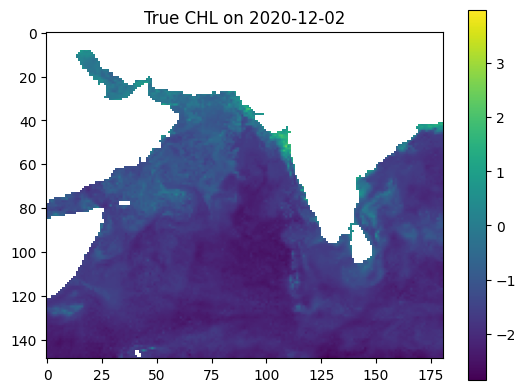

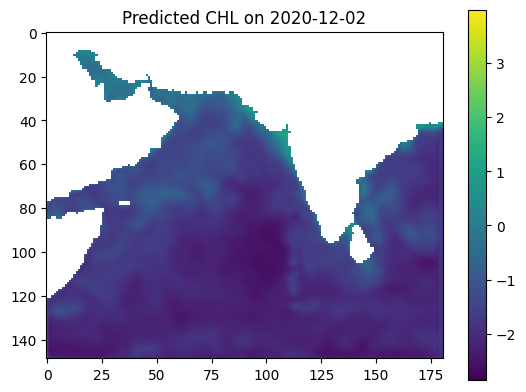

In [40]:
date_to_predict = '2020-12-02'
true_output = np.log(zarr_CHL.sel(time=date_to_predict).CHL)

date_index = (np.datetime64(date_to_predict) - np.datetime64('2020-01-01')).item().days
input = X[date_index - window_size]
input = np.array(input)
predicted_output = model.predict(input[np.newaxis, ...])[0]

predicted_output = predicted_output[:,:,0]

land_mask = np.load(r"E:\24SU Varanasi Intern\参考资料\2023_Intern_Material\land_mask_nc.npy")
predicted_output[land_mask] = np.nan

# true_output_2 = (model_data[-1])[date_index]

vmax = np.nanmax((true_output, predicted_output))
vmin = np.nanmin((true_output, predicted_output))

plt.imshow(true_output, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'True CHL on {date_to_predict}')
plt.show()

plt.imshow(predicted_output, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Predicted CHL on {date_to_predict}')
plt.show()



In [41]:
def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))


predicted_mae = compute_mae(np.array(true_output), predicted_output)
print(f"MAE between Predicted Output and True Output: {predicted_mae}")

prev_day_dt64 = np.datetime64(date_to_predict) - np.timedelta64(1, 'D')
prev_day = np.datetime_as_string(prev_day_dt64, unit='D')
prev_day_CHL = np.log(zarr_CHL.sel(time=prev_day).CHL)
last_frame_mae = compute_mae(np.array(prev_day_CHL), np.array(true_output))
print(f"MAE between Last Input Frame and True Output: {last_frame_mae}")

MAE between Predicted Output and True Output: 0.16125544905662537
MAE between Last Input Frame and True Output: 0.13173514604568481


In [33]:
input.shape
input[-1,:,:,-1].shape

(149, 181)

In [37]:
# t = numpy.datetime64('2012-06-30T20:00:00.000000000-0400')
# numpy.datetime_as_string(t, unit='D')
last_day = np.datetime64(date_to_predict) - np.timedelta64(1, 'D')
last_day_str = np.datetime_as_string(last_day, unit='D')
last_day_str

'2020-09-01'

In [31]:
# (np.datetime64('2020-01-03') - np.datetime64('2020-01-01')) / np.timedelta64(1, 'D')
(np.datetime64('2020-01-03') - np.datetime64('2020-01-01')).item().days

2